# Calibration pattern detection and measuring

author: _Erik Rodner_, 2016

In [41]:
%matplotlib inline
import matplotlib.pylab as plt
import skimage
import numpy as np
from scipy.misc import imread
from glob import glob
from skimage import feature
from scipy.spatial.distance import pdist, squareform

## Read and display some example data

In [222]:
images = sorted(glob('/home/rodner/data/moth2/*.jpg'))

In [229]:
imgfn = images[1]
#imgfn = '/home/rodner/data/moth2/Pe-Arc-0007_2mp.jpg'
img = imread(imgfn)
print ("Image file: {}".format(imgfn))

Image file: /home/rodner/data/moth2/Pe-Arc-0002_2mp.jpg


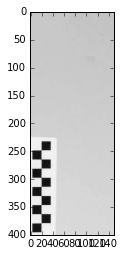

In [234]:
imgr = skimage.color.rgb2gray(img[-400:,:150,:])
plt.imshow(imgr, cmap=plt.cm.gray)

## Detect corners with a corner detector and display them

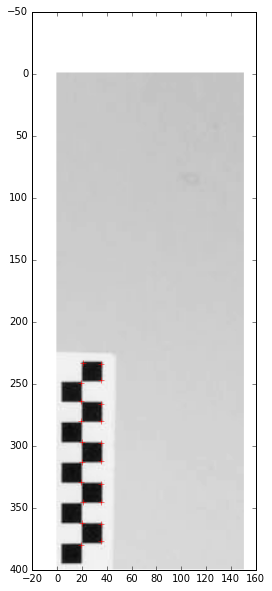

In [235]:
def estimate_corners(imgr):
    response = feature.corner_shi_tomasi(imgr)
    corners = feature.corner_peaks(response, min_distance=11)
    return corners

corners = estimate_corners(imgr)
plt.figure(figsize=(10,10))
plt.imshow(imgr, cmap=plt.cm.gray)
plt.plot(corners[:,1], corners[:,0], 'r+', linewidth=5)

## Analyze pairwise corner distances

The idea here is that the statistics of pairwise corner distances are very characterized by multiplies of the box length, 
which is exactly the value we are searching for.

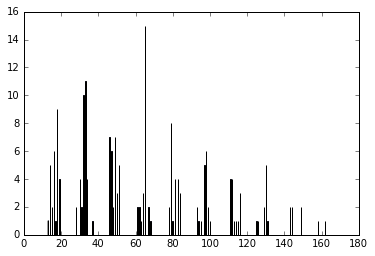

In [236]:
A = pdist(corners, metric='cityblock')
plt.hist(A, bins=800)
plt.show()

As can be seen, the peaks have nearly a constant distance. This is the box width. We now determine this length by computing the distance that results in the minimum quantization error.

In [238]:
def optimize_quant_error(A, verbose=False):
    smallest_quant_error = float("inf")
    for d in np.arange(10.0,100.0,0.25):
        grid = np.arange(0,np.max(A)+d,d)

        # compute quantization error
        bins = (grid[:-1]+grid[1:])/2.0
        prototypes = grid[1:-1]
        bin_assignment = np.digitize(A, bins) - 1
        bin_assignment[bin_assignment==-1] = 0
        bin_assignment[bin_assignment==len(prototypes)] = len(prototypes)-1
    
        # quantization error with BIC model selection
        # adhoc version
        n = len(A)
        quant_error = np.linalg.norm(A - prototypes[bin_assignment]) + len(prototypes)*np.log(n)
        # theoretically derived criterion
        #quant_error = n*np.log(2*np.pi) + np.linalg.norm(A - prototypes[bin_assignment])**2 + len(prototypes)*np.log(n)
       
        if verbose:
            print ("{}: {} {}".format(d, quant_error, unused_bins))
        if quant_error < smallest_quant_error:
            smallest_quant_error = quant_error
            best_distance = d

    return best_distance
    
print ("Box width estimate: {}".format(optimize_quant_error(A)))

Box width estimate: 16.0


This method has a severe bias towards smaller box width. Exactly half of the box width would for example naturally result in the same quantization error. Therefore we added a _BIC information criterion_ (https://en.wikipedia.org/wiki/Bayesian_information_criterion).

## Theoretical analysis of the pairwise distances

We analyze the histogram of pairwise distances for a perfect regular grid

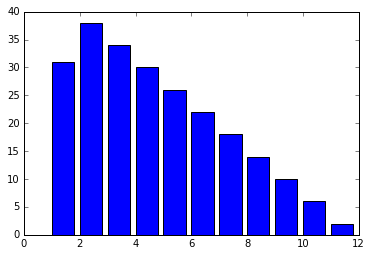

In [198]:
n = 10
Y, X = np.meshgrid(range(n+1), [0,1])
P = np.vstack([np.ravel(Y),np.ravel(X)]).T
A = pdist(P, metric='cityblock')
h = np.bincount(A.astype('int'))
plt.bar(range(len(h)), h)
plt.show()

## Putting it all together and processing all images

In [239]:
def estimate_calibration_length(img, crop_left=150, crop_bottom=400):
    imgr = skimage.color.rgb2gray(img[-crop_bottom:,:crop_left,:])
    corners = estimate_corners(imgr)
    A = pdist(corners, metric='cityblock')
    return optimize_quant_error(A)

In [240]:
from ipywidgets import FloatProgress
from IPython.display import display
from time import sleep
from os.path import basename
pb = FloatProgress(min=0, max=len(images)-1)

In [241]:
display(pb)
cal_len = {}
for index, imgfn in enumerate(images):
    img = imread(imgfn)
    calibration_length = estimate_calibration_length(img)
    #print ("{}: {}".format(imgfn, calibration_length))
    pb.value = index
    pb.description = basename(imgfn)
    cal_len[basename(imgfn)]=calibration_length

## Combine calibration lengths with segmentation statistics

In [245]:
import json

In [246]:
with open('moth2-stats.json', 'r') as f:
    seginfo = json.load(f)
    stats = seginfo['stats']

In [249]:
with open('stats.csv', 'w') as csvout:
    csvout.write("# image_filename, calibration_length, area, width, height, brightness")
    for imgfn in sorted(cal_len):
        s = stats[imgfn]
        cal_length = cal_len[imgfn]
        area = s['c-area']/(cal_length**2)
        width = (s['c-xmax']-s['c-xmin'])/cal_length
        height = (s['c-ymax']-s['c-ymin'])/cal_length
        brightness = s['median-v']
        csvout.write ("{}, {}, {}, {}, {}\n".format(imgfn, cal_length, area, width, height, brightness))